In [7]:
# Import External Packages
import numpy as np
import psytrack as psy
import pandas as pd
import matplotlib.pyplot as plt
import pickle 
import copy
import os

# Importing Custom Functions
import helperFns as mf
import plotFns as psyplt

curPath = os.path.abspath(os.getcwd())

In [ ]:
# In this notebook, we will clean and transform the behavioral data for mouse JC059 before fitting a dynamic GLM using 
# PsyTrack (Roy et al, 2021). We will then vizualize the category-conditional accuracy traces for the behavioral data,
# the dynamic weights of the GLM, and the extent to which we can recover the original behavioral traces from the GLM 
# weights.

In [3]:
## First, we will extract GLM weight trajectories from behavioral data for mouse JC059. Some elements are adapted from Roy et al, 2021. 

IDs = ('JC059',)

untilTesting = False # We're removing some of the sessions at the end to make sure that the mice "end" at similar accuracies

saveDat = True # Saves data in folder "new_data"

weights = {'bias': 1, # Bias term is incorporated
           's_high': 1,
           's_low': 1}

K = np.sum([weights[i] for i in weights.keys()])

hyper= {'sigInit': 2**4.,      # A large value for all weights that will not be optimized
        'sigma': [2**-4.]*K,   # Sigma for each weight, to be optimized
        'sigDay': 2**-4.}      # Sigma across session boundaries, to be optimized

optList = ['sigma','sigDay'] # Optimize sigma for each weight and across sessions

for ID in IDs:

    print('Starting ' + ID)
    
# Clean and transform behavioral data to prepare for input into GLM

    keyword = "training"
    stc = 'training'
    
    cutoff = 60
    numSessions = None
    accCutoff = 0
    tD = mf.getD(ID, keyword = keyword, cutoff = cutoff, accCutoff = accCutoff, sessionCutoff = numSessions, txt = None, untilTesting = untilTesting)    
    tD2 = copy.deepcopy(tD)

# Input behavioral data into GLM

    hyp, evd, wMode, hess_info = psy.hyperOpt(tD2, hyper, weights, optList)

    psytrack = {
        'wMode': wMode,
        'weights': weights,
        'hyp': hyp,
    }

    tD['psytrack'] = psytrack

# Make folder and save data

    tmp = 'new_data/with_bias_learning/'
   
    if not os.path.isdir(tmp):
        os.makedirs(tmp)

    if saveDat:
        saveName = tmp + "{}_trainingDataBias.pkl".format(ID)
        with open(saveName, 'wb') as f:
            pickle.dump(tD, f)


Starting JC059


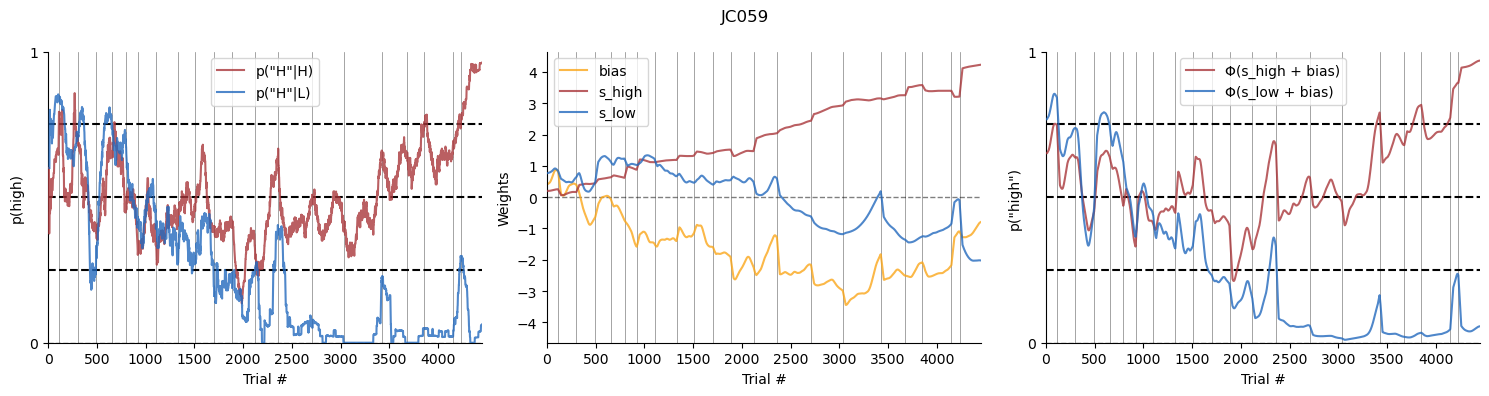

In [6]:
# Now that we've transformed and saved JC059's behavioral data, we can plot both the original data and the GLM weights. 
# The code used to plot these weights is adapted from Roy et al, 2021.

dataBase =  os.path.abspath(os.path.join(curPath,"new_data/with_bias_learning"))

tmp = 0
DFt = []

tmpp = 0
DFfit = []

for ID in IDs:

    plt.rcParams['figure.figsize'] = [15, 4]        
    plt.rcParams['figure.dpi'] = 100

    fig, axes = plt.subplot_mosaic(
        [["left",   "middle",  "right"]],
    )           

# Load data
    file = mf.find_files('.pkl', ID + '_trainingDataBias', dataBase)[0]
    with open(file, 'rb') as f:
        loaded_dict = pickle.load(f)

# Extract and smooth behavioral data for visualization
    acc = np.array(loaded_dict['correct'])
    cat = np.array(loaded_dict['answer'])
    emptyMat = np.empty((1,np.size(acc)))
    emptyMat[:] = np.nan
    emptyMat = emptyMat.squeeze()
    acc_low = emptyMat.copy()
    acc_high = emptyMat.copy()
    acc_low[cat == 1] = acc[cat == 1]
    acc_high[cat == 2] = acc[cat == 2]
    acc_low = pd.Series(acc_low).rolling(100,5).apply(lambda x : np.nanmean(x))
    acc_high = pd.Series(acc_high).rolling(100,5).apply(lambda x : np.nanmean(x))

    wModeRaw = np.vstack([acc_high, 1-acc_low])
    weights_raw = {
        'p("H"|H)': 1,
        'p("H"|L)': 1
    }

    fig_weights = psyplt.plot_weights(wModeRaw, weights_raw, ax = axes["left"], days=loaded_dict["dayLength"])
    fig_weights.set_ylim(0,1)
    fig_weights.axhline(0.5, color = 'k', linestyle = '--')
    fig_weights.axhline(0.25, color = 'k', linestyle = '--')
    fig_weights.axhline(0.75, color = 'k', linestyle = '--')
    fig_weights.set_ylabel('p(high)')
    fig_weights.legend()

# Extract and visualize dynamic GLM weights
    wMode = loaded_dict['psytrack']['wMode']
    temp =  np.array(list(loaded_dict['psytrack']['weights'].keys()))
    weights = loaded_dict['psytrack']['weights']

    wModeT = wMode.copy()

    for ii, wi in enumerate(wModeT):
        wModeT[ii] = pd.Series(wi).rolling(30,5).apply(lambda x : np.nanmean(x))

    fig_weights = psyplt.plot_weights(wModeT, weights, ax = axes["middle"], days=loaded_dict["dayLength"])
    fig_weights.legend()

# Extract and transform dynamic GLM weights to recover category-conditional accuracy traces, and visualize.
    if 'bias' in temp:
        weightsT = weights.copy()
        weightsT.pop('bias')
        weightsT['Φ(s_high + bias)'] = weightsT.pop('s_high')
        weightsT['Φ(s_low + bias)'] = weightsT.pop('s_low')

        wModeT = wMode.copy()
        bias = wModeT[temp == 'bias']
        wModeT = wModeT[temp != 'bias']
        wModeT = wModeT + bias
        wModeT = 1/(1+np.exp(-1 * wModeT))
    else:
        weightsT = weights.copy()
        wModeT = wMode.copy()
        wModeT = 1/(1+np.exp(-1 * wModeT)) 

    for ii, wi in enumerate(wModeT):
        wModeT[ii] = pd.Series(wi).rolling(30,5).apply(lambda x : np.nanmean(x))

    fig_weights = psyplt.plot_weights(wModeT, weightsT, ax = axes["right"], days=loaded_dict["dayLength"])
    fig_weights.set_ylim(0,1)
    fig_weights.axhline(0.5, color = 'k', linestyle = '--')
    fig_weights.axhline(0.25, color = 'k', linestyle = '--')
    fig_weights.axhline(0.75, color = 'k', linestyle = '--')
    fig_weights.set_ylabel('p("high")')
    fig_weights.legend()

    fig.suptitle(ID)
    fig.tight_layout()

In [ ]:
# We can see that the GLM weights do lose some temporal information, but still capture dynamics within- and across- sessions.